In [1]:
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
import nltk, string

from re import sub
from decimal import Decimal
from collections import defaultdict
from statistics import median

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Specify Airbnb data file
DATA_FILE = "airbnb_paris_listings.csv"

# Specify what percent of data for training/validation/test
TRAINING_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1

# Pull out stop words in both English and French (Paris Dataset)
punctuation = set(string.punctuation)
stopwords = set()
for word in nltk.corpus.stopwords.words("english"):
    stopwords.add(word)
for word in nltk.corpus.stopwords.words("french"):
    stopwords.add(word)

In [3]:
# Read in entire Airbnb dataset
data = pd.read_csv(DATA_FILE)

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Get basic data statistics
dataPriceList = []
for index, row in data.iterrows():
    dataPriceList.append(float(sub(r'[^\d.]', '', row['price'])))
print("Min:", min(dataPriceList))
print("Max:", max(dataPriceList))
print("Mean:", np.mean(dataPriceList))
print("Median:", median(dataPriceList))
print("STD:", np.std(dataPriceList))

Min: 0.0
Max: 25000.0
Mean: 109.207177041308
Median: 79.0
STD: 232.08036866918397


In [5]:
# Fill null data with 0
data = data.fillna(0)

# Shuffle data and redo index
data = data.sample(frac=1).reset_index(drop=True)

# Rank Arbnb listing prices in order of least to max
priceTemp = []
for index, row in data.iterrows():
    priceTemp.append( float(sub(r'[^\d.]', '', row['price'])) )
priceTemp.sort()
print("Total Initial Data:", len(data))
print("Highest Price in Original Data:", max(priceTemp))

# Discard listing at the top 1%
priceWithPercentHigherThanX = priceTemp[int(len(priceTemp) * 0.99)]
print("Discarding prices higher than:", priceWithPercentHigherThanX)
regularPricing = []
discardedPriceCount = 0
for index, row in data.iterrows():
    if float(sub(r'[^\d.]', '', row['price'])) >= priceWithPercentHigherThanX:
        regularPricing.append( False )
        discardedPriceCount += 1
    else:
        regularPricing.append( True )
data = data[ regularPricing ]
print("Discarded", discardedPriceCount, "prices")
print("Total Data After Discard:", len(data))

Total Initial Data: 61223
Highest Price in Original Data: 25000.0
Discarding prices higher than: 650.0
Discarded 627 prices
Total Data After Discard: 60596


In [6]:
# Get basic data statistics
dataPriceList = []
for index, row in data.iterrows():
    dataPriceList.append(float(sub(r'[^\d.]', '', row['price'])))
print("Min:", min(dataPriceList))
print("Max:", max(dataPriceList))
print("Mean:", np.mean(dataPriceList))
print("Median:", median(dataPriceList))
print("STD:", np.std(dataPriceList))

Min: 0.0
Max: 644.0
Mean: 97.66568750412569
Median: 78.0
STD: 73.36354819392164


In [7]:
def getAmenityList(datum):
    """
    Get a list of all the possible amenities offered on Airbnb listings.
    Determine the average price associated with that particular amenity
    and graph the top 20 amenities with the highest price association.
    """
    
    # Get list of amenities
    amenityList = set()
    amenityAvgPrice = defaultdict(float)
    amenityCount = defaultdict(int)
    for index, row in datum.iterrows():
        price = float(sub(r'[^\d.]', '', row['price']))
        amenities = set(row['amenities'].replace('"', "").replace('{', "").replace('}', "").split(','))
        for amenity in amenities:
            if "translation missing" not in amenity and amenity != '':
                amenityList.add( amenity )
                amenityCount[amenity] += 1
                amenityAvgPrice[amenity] += price
    amenityList = list(amenityList)
    
    # Calculate average price of each amenity
    for amenity in amenityAvgPrice:
        amenityAvgPrice[amenity] = amenityAvgPrice[amenity] / amenityCount[amenity]
    
    # Sort amenity based on average price (descending order)
    amenitySortedByAvgPrice = [[amenityAvgPrice[amenity], amenity] for amenity in amenityAvgPrice]
    amenitySortedByAvgPrice.sort()
    amenitySortedByAvgPrice.reverse()
    
    # Graph top 20 expensive amenities
    avgPrice = [(amenity[0]) for amenity in amenitySortedByAvgPrice[:20]]
    amenities = [(amenity[1]) for amenity in amenitySortedByAvgPrice[:20]]
    
    # Label graph
    plt.barh(np.arange(len(amenities)), list(reversed(avgPrice)), align='center', alpha=0.5)
    plt.yticks(np.arange(len(amenities)), list(reversed(amenities)))
    plt.xlim(left=110)
    plt.xlabel("Average AirBnB Price/Night in Euro")
    plt.ylabel("Amenity")
    plt.title("Amenity Correlation To Pricing")
    plt.show()

    return amenityList

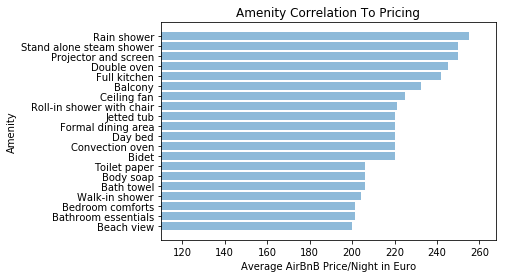

In [8]:
amenityList = getAmenityList(data)

In [9]:
def getExpensiveWords(datum):
    """
    Determine the top 2000 used words that are not stop words and return
    the top 1000 words from that list with the highest average price/night
    association. Then graph the top 20 words from that list for
    visualization.
    """
    
    wordCount = defaultdict(int)
    wordAvgPrice = defaultdict(float)

    # Count up words and their associated price
    for index, row in datum.iterrows():
        description = ''.join([c for c in str(row['description']).lower() if not c in punctuation])
        descriptionWords = [(word) for word in description.split() if word not in stopwords]
        price = float(sub(r'[^\d.]', '', row['price']))
        for word in descriptionWords:
            wordCount[word] += 1
            wordAvgPrice[word] += price
    for word in wordAvgPrice:
        wordAvgPrice[word] = wordAvgPrice[word] / wordCount[word]

    # Sort the word count
    wordCountTemp = [[wordCount[word], word] for word in wordCount]
    wordCountTemp.sort()
    wordCountTemp.reverse()
    
    # Get the top 2000 words and rank by price
    wordAvgPriceTemp = [[wordAvgPrice[word[1]], word[1], wordCount[word[1]]] for word in wordCountTemp[:2000]]
    wordAvgPriceTemp.sort()
    wordAvgPriceTemp.reverse()
    
    # Graph expensive words
    avgPrice = [(word[0]) for word in wordAvgPriceTemp[:20]]
    words = [(word[1]) for word in wordAvgPriceTemp[:20]]
    
    # Label the graphs
    plt.barh(np.arange(len(words)), list(reversed(avgPrice)), align='center', alpha=0.5)
    plt.yticks(np.arange(len(words)), list(reversed(words)))
    plt.xlim(left=140)
    plt.xlabel("Average AirBnB Price/Night in Euro")
    plt.ylabel("Word")
    plt.title("Description Words to Pricing")
    plt.show()
    
    # Return the top 1000 from the 2000 most popular words with the
    # highest price per night association
    return wordAvgPriceTemp[:1000]

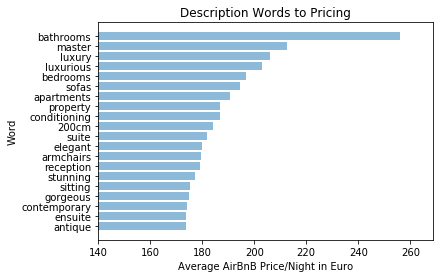

In [10]:
expensiveWordList = list(getExpensiveWords(data))

In [11]:
def createOneHotVector(categories):
    """
    Given a list of categories, come up with a one hot vector to
    represent each category and return the category to one hot vector
    mapping.
    """
    
    categoryOneHotVector = dict()
    index = 0
    for category in categories:
        oneHotVector = []
        for i in range(len(categories)):
            oneHotVector.append( 1 if i == index else 0 )
        index += 1
        categoryOneHotVector[ category ] = oneHotVector
    
    return categoryOneHotVector

In [12]:
# Create one hot vectors
propertyOneHotVector = createOneHotVector( data.property_type.unique() )
roomTypeOneHotVector = createOneHotVector( data.room_type.unique() )
smartLocationOneHotVector = createOneHotVector( data.smart_location.unique() )
streetOneHotVector = createOneHotVector( data.street.unique() )
hostNeighbourhoodOneHotVector = createOneHotVector( data.host_neighbourhood.unique() )
bedTypeOneHotVector = createOneHotVector( data.bed_type.unique() )

In [13]:
# Number of unique street names from dataset
# len(data.street.unique())

In [14]:
def plotPriceGeolocation(datum):
    """
    Given the Airbnb listing dataset, graph the listing price by
    geolocation.
    """
    
    longitude = []
    latitude = []
    price = []
    
    # Determine the X (longitude), Y (latitude), and Z (price) axis
    for index, row in datum.iterrows():
        longitude.append(row['longitude'])
        latitude.append(row['latitude'])
        price.append( float(sub(r'[^\d.]', '', row['price'])) )
    
    # Sort listing by price/night in ascending order
    combined = [[price[i], longitude[i], latitude[i]] for i in range(len(price))]
    combined.sort()
    
    # Store sorted listing into appropriate axis location
    price = [(f[0]) for f in combined]
    longitude = [(f[1]) for f in combined]
    latitude = [(f[2]) for f in combined]
       
    # Graph the data
    maxPrice = max(price)
    normalizedPrice = [( i / maxPrice * 255) for i in price]
    plt.scatter(longitude, latitude, c=price, s=3, alpha=1 )
    plt.title("AirBnB Price/Night By Location")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.colorbar()
    plt.savefig("AirBnB Price.png")
    plt.show()
    

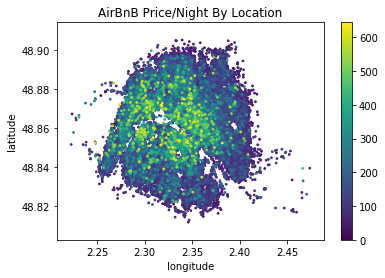

In [15]:
plotPriceGeolocation(data)

In [16]:
def plotPriceDistribution(datum):
    """
    Plot a histogram of the price distribution of the given
    Airbnb listing dataset
    """
    
    columnWidth = 40
    
    # Parse price into decimal value
    priceList = []
    for index, row in datum.iterrows():
        priceList.append( float(sub(r'[^\d.]', '', row['price'])) )

    # Determine the max price value and create price buckets
    maxPrice = max(priceList)
    bucket = defaultdict(int)
    
    # Determine how many listings fall under each price bucket
    for price in priceList:
        priceUnder = int(price / columnWidth) + 1 if price % columnWidth != 0 else int(price/columnWidth)
        priceUnder = priceUnder * columnWidth
        bucket[ priceUnder ] += 1
        
    # Create axises for the histogram
    countList = []
    categoryList = []
    currentPrice = columnWidth
    while currentPrice < (maxPrice + columnWidth):
        categoryList.append(currentPrice)
        countList.append(bucket[currentPrice])
        currentPrice += columnWidth
        
    # Graph the histogram of price distribution
    plt.bar(np.arange(len(categoryList)), countList, align='center', alpha=0.5)
    plt.xticks(np.arange(len(categoryList)), categoryList)
    plt.xlabel("AirBnB Price/Night in Euro")
    plt.ylabel("Total Count")
    plt.title("Price Distribution")
    
    plt.savefig("Price Distribution.png")
    
    plt.show()

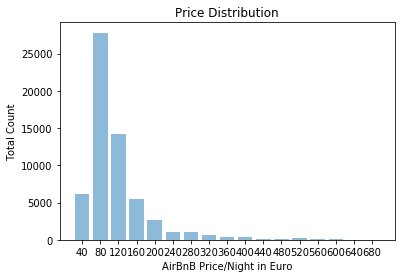

In [17]:
plotPriceDistribution(data)

In [18]:
def featureGenerator(datum):
    """
    Generate features for supervised learning for each entry in the
    Airbnb listing dataset
    """
    
    featureBuilder = []
    
    for index, row in datum.iterrows():
        
        # Basic quantitative data
        feature = [1,
                   row['latitude'],
                   row['longitude'],
                   row['accommodates'],
                   row['bathrooms'],
                   row['bedrooms'],
                   row['beds'],
                   row['guests_included'],
                   row['minimum_nights'],
                   row['host_identity_verified'] == 't',
                   row['review_scores_rating'],
                   row['review_scores_accuracy'],
                   row['review_scores_cleanliness'],
                   row['review_scores_checkin'],
                   row['review_scores_communication'],
                   row['review_scores_location'],
                  ]
        
        # One hot vector for different category
        feature.extend(propertyOneHotVector[row['property_type']])
        feature.extend(roomTypeOneHotVector[row['room_type']])
        #feature.extend(smartLocationOneHotVector[row['smart_location']])
        feature.extend(streetOneHotVector[row['street']])
        feature.extend(hostNeighbourhoodOneHotVector[row['host_neighbourhood']])
        feature.extend(bedTypeOneHotVector[row['bed_type']])
        
        # Yes (1) or No (0) for if listing offer the specified amenity
        amenities = row['amenities'].replace('"', "").replace('{', "").replace('}', "").split(',')
        for amenity in amenityList:
            feature.extend([amenity in amenities])
            
        # Yes (1) or No (0) for if an expensive word appeared in description
        description = ''.join([c for c in str(row['description']).lower() if not c in punctuation])
        descriptionWords = set([(word) for word in description.split() if word not in stopwords])
        for word in expensiveWordList:
            feature.extend([word[1] in descriptionWords])
        
        feature.extend([1])
        featureBuilder.append(feature)
        
    return preprocessing.scale(featureBuilder)

In [19]:
def generateY(datum):
    """
    Generate the expected output for supervised learning via regression
    """
    expected_Y = []
    for index, row in datum.iterrows():
        expected_Y.append( Decimal(sub(r'[^\d.]', '', row['price'])))
        
    return expected_Y

In [20]:
# Generate feature and expected output for entire dataset
X = featureGenerator(data)
Y = generateY(data)

# Use first [TRAINING_SIZE] from dataset as the training set
X_train = X[:int(len(X) * TRAINING_SIZE)]
Y_train = Y[:int(len(X) * TRAINING_SIZE)]

# Use next [VALIDATION_SIZE] from dataset as validation set
X_validation = X[int(len(X) * TRAINING_SIZE) : int(len(X) * (TRAINING_SIZE + VALIDATION_SIZE))]
Y_validation = Y[int(len(X) * TRAINING_SIZE) : int(len(X) * (TRAINING_SIZE + VALIDATION_SIZE))]

# Use the remaining from dataset as test set
X_test = X[ int(len(X) * (TRAINING_SIZE + VALIDATION_SIZE)) : ]
Y_test = Y[ int(len(X) * (TRAINING_SIZE + VALIDATION_SIZE)) : ]

In [21]:
# Baseline model 1 - Every prediction is the median (Training Set)
print("TRAINING SET: Calculating Median Baseline...")
print("R^2:", r2_score(Y_train, [median(dataPriceList)] * len(Y_train)))
print("MSE:", mean_squared_error(Y_train, [median(dataPriceList)] * len(Y_train)))

# Baseline model 2 - Every prediction is the mean (Training Set)
print("\nTRAINING SET: Calculating Mean Baseline...")
print("R^2:", r2_score(Y_train, [np.mean(dataPriceList)] * len(Y_train)))
print("MSE:", mean_squared_error(Y_train, [np.mean(dataPriceList)] * len(Y_train)))

TRAINING SET: Calculating Median Baseline...
R^2: -0.07258946530976562
MSE: 5811.586888357125

TRAINING SET: Calculating Mean Baseline...
R^2: -5.107408013627079e-06
MSE: 5418.304727451491


In [22]:
# Baseline model - Every prediction is the median (Test Set)
print("TEST SET: Calculating Median Baseline...")
print("R^2:", r2_score(Y_test, [median(dataPriceList)] * len(Y_test)))
print("MSE:", mean_squared_error(Y_test, [median(dataPriceList)] * len(Y_test)))

print("\nTEST SET: Calculating Mean Baseline...")
print("R^2:", r2_score(Y_test, [np.mean(dataPriceList)] * len(Y_test)))
print("MSE:", mean_squared_error(Y_test, [np.mean(dataPriceList)] * len(Y_test)))

TEST SET: Calculating Median Baseline...
R^2: -0.06970372438987882
MSE: 5650.796534653466

TEST SET: Calculating Mean Baseline...
R^2: -4.302526943766871e-05
MSE: 5282.808251340864


In [23]:
# Train using Random Forest Regression
clf = RandomForestRegressor(max_depth=17, n_estimators=50, n_jobs=-1)
clf.fit(X_train, Y_train)

# Predict Airbnb Listing prices on validation set
print("Predicted:", clf.predict(X_validation[-10:]))
print("Actual:", Y_validation[-10:])
print()

# Find R^2 and MSE on training set
print("-- Training Set --")
print("R^2:", clf.score(X_train, Y_train))
print("MSE:", mean_squared_error(Y_train, clf.predict(X_train)))

# Find R^2 and MSE on validation set
print("\n-- Validation Set --")
print("R^2:", clf.score(X_validation, Y_validation))
print("MSE:", mean_squared_error(Y_validation, clf.predict(X_validation)))

# Find R^2 and MSE on testing set
print("\n-- Test Set --")
print("R^2:", clf.score(X_test, Y_test))
print("MSE:", mean_squared_error(Y_test, clf.predict(X_test)))

Predicted: [312.70145222 101.54850821  68.58084248  68.81242306  91.08611227
 154.95385306 120.86162858  89.49881568  56.17910399  57.19290969]
Actual: [Decimal('240.00'), Decimal('80.00'), Decimal('70.00'), Decimal('110.00'), Decimal('65.00'), Decimal('200.00'), Decimal('120.00'), Decimal('60.00'), Decimal('70.00'), Decimal('70.00')]

-- Training Set --
R^2: 0.8405339946297468
MSE: 864.0309978066057

-- Validation Set --
R^2: 0.624852721886032
MSE: 1947.821136185434

-- Test Set --
R^2: 0.6282464412545234
MSE: 1963.818273795578


In [24]:
# List the feature importance of the Random Forest Regression
#np.argsort(clf.feature_importances_)[-10:]
#np.sort(clf.feature_importances_)[-10:]

In [25]:
# Train using Ridge Regression using various alpha values
highest_clf_MSE = float("inf")
highest_clf = None
for alphaToTest in [0.001, 0.01, 0.1, 1,10, 100]:
    clf = Ridge(alpha=alphaToTest)
    clf.fit(X_train, Y_train)
    
    # Test model on validation set
    MSE = mean_squared_error(Y_validation, clf.predict(X_validation))
    if MSE < highest_clf_MSE:
        highest_clf_MSE = MSE
        highest_clf = clf
    
# Determine the model with the highest score on the validation set
clf = highest_clf
    
# Predict Airbnb Listing prices on validation set
print("Predicted:", clf.predict(X_validation[-10:]))
print("Actual:", Y_validation[-10:])
print("highest alpha:", clf.alpha)

# Find R^2 and MSE on training set
print("-- Training Set --")
print("R^2:", clf.score(X_train, Y_train))
print("MSE:", mean_squared_error(Y_train, clf.predict(X_train)))

# Find R^2 and MSE on validation set
print("\n-- Validation Set --")
print("R^2:", clf.score(X_validation, Y_validation))
print("MSE:", mean_squared_error(Y_validation, clf.predict(X_validation)))

# Find R^2 and MSE on test set
print("\n-- Test Set --")
print("R^2:", clf.score(X_test, Y_test))
print("MSE:", mean_squared_error(Y_test, clf.predict(X_test)))

Predicted: [310.83961449 100.04681881  61.20654623  97.04528046  70.1267734
 144.69977094 148.8428729   63.29296307  45.62013052  33.5049807 ]
Actual: [Decimal('240.00'), Decimal('80.00'), Decimal('70.00'), Decimal('110.00'), Decimal('65.00'), Decimal('200.00'), Decimal('120.00'), Decimal('60.00'), Decimal('70.00'), Decimal('70.00')]
highest alpha: 100
-- Training Set --
R^2: 0.6253178748050178
MSE: 2030.1315615253375

-- Validation Set --
R^2: 0.58882498951489
MSE: 2134.8825456514614

-- Test Set --
R^2: 0.5893685434991587
MSE: 2169.1939165100416


In [26]:
# Find the Ridge Coefficient of each feature
#np.argsort(clf.coef_)[:10]
#np.sort(clf.coef_)[-10:]

In [27]:
# Train using regular linear regression with all CPU threads
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, Y_train)

# Predict Airbnb Listing prices on validation set
print("Predicted:", clf.predict(X_validation[-10:]))
print("Actual:", Y_validation[-10:])
print()

# Find R^2 and MSE on training set
print("-- Training Set --")
print("R^2:", clf.score(X_train, Y_train))
print("MSE:", mean_squared_error(Y_train, clf.predict(X_train)))

# Find R^2 and MSE on validation set
print("\n-- Validation Set --")
print("R^2:", clf.score(X_validation, Y_validation))
print("MSE:", mean_squared_error(Y_validation, clf.predict(X_validation)))

# Find R^2 and MSE on test set
print("\n-- Test Set --")
print("R^2:", clf.score(X_test, Y_test))
print("MSE:", mean_squared_error(Y_test, clf.predict(X_test)))

Predicted: [312.41210938  99.81445312  61.83007812  96.80273438  76.58203125
 146.04882812 146.60742188  64.34960938  45.42773438  31.77148438]
Actual: [Decimal('240.00'), Decimal('80.00'), Decimal('70.00'), Decimal('110.00'), Decimal('65.00'), Decimal('200.00'), Decimal('120.00'), Decimal('60.00'), Decimal('70.00'), Decimal('70.00')]

-- Training Set --
R^2: 0.6245070013345531
MSE: 2034.525098644135

-- Validation Set --
R^2: -3.125552730980915e+26
MSE: 1.6228340246193177e+30

-- Test Set --
R^2: -2.5085016166768434e+26
MSE: 1.3251362895623327e+30


In [28]:
# Train using Lasso Regression with various alpha values
highest_clf_MSE = float("inf")
highest_clf = None
for alphaToTest in [0.001, 0.01, 0.1, 1,10, 100]:
    clf = Lasso(alpha=alphaToTest)
    clf.fit(X_train, Y_train)
    
    # Test model on validation set
    MSE = mean_squared_error(Y_validation, clf.predict(X_validation))
    if MSE < highest_clf_MSE:
        highest_clf_MSE = MSE
        highest_clf = clf
    
# Determine model with the highest score on the validation set
clf = highest_clf
    
# Predict Airbnb Listing prices on validation set
print("Predicted:", clf.predict(X_validation[-10:]))
print("Actual:", Y_validation[-10:])
print("highest alpha:", clf.alpha)

# Find R^2 and MSE on training set
print("-- Training Set --")
print("R^2:", clf.score(X_train, Y_train))
print("MSE:", mean_squared_error(Y_train, clf.predict(X_train)))

# Find R^2 and MSE on validation set
print("\n-- Validation Set --")
print("R^2:", clf.score(X_validation, Y_validation))
print("MSE:", mean_squared_error(Y_validation, clf.predict(X_validation)))

# Find R^2 and MSE on test set
print("\n-- Test Set --")
print("R^2:", clf.score(X_test, Y_test))
print("MSE:", mean_squared_error(Y_test, clf.predict(X_test)))

C:\Users\lenovo\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Predicted: [297.88190088  99.47202061  60.68020243  96.42172201  55.19140804
 142.75111884 144.23842908  66.01617009  45.81830986  47.11229886]
Actual: [Decimal('240.00'), Decimal('80.00'), Decimal('70.00'), Decimal('110.00'), Decimal('65.00'), Decimal('200.00'), Decimal('120.00'), Decimal('60.00'), Decimal('70.00'), Decimal('70.00')]
highest alpha: 0.1
-- Training Set --
R^2: 0.6224561670249327
MSE: 2045.6370871257113

-- Validation Set --
R^2: 0.5952102878261138
MSE: 2101.7291156866236

-- Test Set --
R^2: 0.5980302631165435
MSE: 2123.4376813188674


In [29]:
def plotBathroomBedroomPricing(datum):
    """
    Plot the average price per night for the given number of bathrooms
    and bedrooms a listing offered.
    """
    
    avgPrice = defaultdict(float)
    count = defaultdict(int)
    
    # Find the price associated with each number of bathroom/bedroom combo
    plottingData = []
    for index, row in datum.iterrows():
        price = float(sub(r'[^\d.]', '', row['price']))
        numBathroom = row['bathrooms']
        numBedroom = row['bedrooms']
        key = str(numBathroom) + "-" + str(numBedroom)
        avgPrice[key] += price
        count[key] += 1
        
    # Determine the axis (# bathroom/bedroom) and its average price
    for key in avgPrice:
        avgPrice[key] = avgPrice[key] / count[key]
    for key in avgPrice:
        price = avgPrice[key]
        numBathroom = float(key.split("-")[0])
        numBedroom = float(key.split("-")[1])
        plottingData.append([price, numBathroom, numBedroom])
        
    # Begin plotting
    plottingData.sort()
    maxPrice = plottingData[-1:][0][0]
    pricePlot       = [(row[0]) for row in plottingData]
    numBathroomPlot = [(row[1]) for row in plottingData]
    numBedroomPlot  = [(row[2]) for row in plottingData]
    
    normalizedPrice = [( i / maxPrice * 255) for i in pricePlot]
    plt.scatter(numBathroomPlot, numBedroomPlot, c=pricePlot, s=40, alpha=0.6 )
    plt.title("AirBnB Price/Night By Number of Bedrooms and Bathrooms")
    plt.xlabel("Number of Bathrooms")
    plt.ylabel("Number of Bedrooms")
    plt.xlim(left=-0.5,right=10)
    plt.ylim(bottom=-0.5,top=10)
    plt.colorbar()
    plt.show()

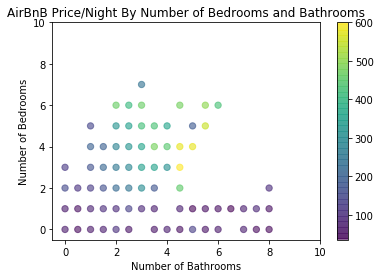

In [30]:
plotBathroomBedroomPricing(data)